# Step 2: Parameter Estimation Methods Comparison

**Goal**: Explain how the authors estimate parameters in the adaptive Heston paper, and compare with other MLE methods (Simplex, EM algorithm).

This notebook uses the refactored `HestonModel` class for a clean, modular approach.


## Project Requirements

From Professor Chopin's email:

> 2. explain how the authors estimate the theta based on real data, and compare to other (MLE) methods, see the corresponding chapter. In particular, discuss you could use the simplex and / or the EM algorithm.

This notebook addresses:

- **Part A**: Explanation of the paper's approach (NMLE + switching filters)
- **Part B**: Implementation and comparison of different estimation methods:
  - PMMH (Particle Marginal Metropolis-Hastings) - Bayesian approach
  - Simplex (Nelder-Mead) - Direct optimization
  - EM (Expectation-Maximization) - Iterative optimization
- **Part C**: Comparison and analysis of results


In [3]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add parent directory to path to import heston package
sys.path.insert(0, os.path.abspath('../..'))

from heston import HestonModel
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

plt.style.use('ggplot')
print("Setup complete!")


Setup complete!


## Part A: Paper's Approach - NMLE with Switching Filters

### How the Authors Estimate Parameters

The paper "Adaptive calibration of Heston Model using PCRLB based switching Filter" by Kumar Yashaswi uses:

1. **Normal Maximum Likelihood Estimation (NMLE)**: A method that transforms the Heston model to get an exact Gaussian distribution (rather than approximate).

2. **Switching Filter Strategy**: Uses PCRLB (Posterior Cramer-Rao Lower Bound) to switch between different Bayesian filters (EKF, UKF, PF) at each time step.

3. **Alternating Approach**:
   - Use filtering (EKF/UKF/PF) to estimate volatility
   - Use NMLE to estimate parameters (given estimated volatilities)
   - Repeat until convergence

### Key Differences from Our Approach

- **Paper**: Uses NMLE (requires known volatilities) + switching filters
- **Our approach**: Uses PMMH (Bayesian MCMC) which estimates parameters directly from data

### NMLE Method (from paper)

The NMLE formulas require **known volatilities** $V_k$:

$$\\hat{\\kappa} = \\frac{2}{\\delta}\\left(1 + \\frac{\\hat{P}\\delta}{2} \\frac{1}{n}\\sum_{k=1}^n \\frac{1}{V_{k-1}} - \\frac{1}{n}\\sum_{k=1}^n \\sqrt{\\frac{V_k}{V_{k-1}}}\\right)$$

$$\\hat{\\sigma} = \\sqrt{\\frac{4}{\\delta} \\frac{1}{n}\\sum_{k=1}^n \\left[\\sqrt{V_k} - \\sqrt{V_{k-1}} - \\frac{\\delta}{2\\sqrt{V_{k-1}}}(\\hat{P} - \\hat{\\kappa}V_{k-1})\\right]^2}$$

$$\\hat{\\theta} = \\frac{\\hat{P} + \\frac{1}{4}\\hat{\\sigma}^2}{\\hat{\\kappa}}$$

**Note**: Since we use PMMH (which doesn't require known volatilities), we focus on comparing PMMH with other direct optimization methods (Simplex, EM).


## Part B: Comparison of Estimation Methods

We'll compare three different approaches:

1. **PMMH (Particle Marginal Metropolis-Hastings)**: Bayesian MCMC method
2. **Simplex (Nelder-Mead)**: Direct optimization of log-likelihood
3. **EM (Expectation-Maximization)**: Iterative optimization using particle filter

### Load Data

We'll use the same S&P 500 data as in Step 1.


In [18]:
# Initialize model and load data
hest = HestonModel(dt=1 / 252, r=0.04)

print("Loading market data...")
hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")

print(f"\nLoaded {len(hest.data)} observations")
print(f"Date range: {hest.dates[0].date()} to {hest.dates[-1].date()}")

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations


Loading market data...

Loaded 4778 observations
Date range: 2007-01-04 to 2025-12-30


### Method 1: PMMH (Particle Marginal Metropolis-Hastings)

**What it is**: Bayesian MCMC method that samples from the posterior distribution of parameters.

**Advantages**:

- Provides full posterior distribution (not just point estimates)
- Handles uncertainty quantification
- No need for known volatilities

**Disadvantages**:

- Computationally expensive (requires many MCMC iterations)
- Requires prior distributions
- May have mixing issues


In [45]:
# Define prior for PMMH
from particles import distributions as dists

hest = HestonModel(dt=1 / 252, r=0.04)

print("Loading market data...")
hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
prior_dict = {
    'kappa': dists.Gamma(a=2.0, b=1.0),  # Mean ~2, variance ~2
    'theta': dists.Gamma(a=2.0, b=40.0),  # Mean ~0.05, variance ~0.00125
    'sigma': dists.Gamma(a=2.0, b=2.5),  # Mean ~0.8, variance ~0.32
    'rho': dists.Uniform(a=-0.99, b=0.99),  # Correlation
    'v0': dists.Dirac(0.04),  # Fixed initial variance
    'dt': dists.Dirac(1 / 252),  # Fixed daily time step
}

my_prior = dists.StructDist(prior_dict)

print("Running PMMH (this will take several minutes)...")
print(
    "Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000"
)
n_iter = 10000  # Reduced for faster testing

results_pmmh = hest.estimate_parameters(
    method='pmmh',
    n_iter=n_iter,  # Reduced for faster testing
    n_particles=20000,
    prior=my_prior,
    burnin=n_iter // 10,  # 10% burn-in
    verbose=True,
)

params_pmmh = hest.estimated_params.copy()
print("\n=== PMMH Results ===")
for param, value in params_pmmh.items():
    print(f"  {param}: {value:.4f}")

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - this is normal.
INFO:       The particles library doesn't provide progress bars for PMMH.
INFO: Starting PMMH...


Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=2.2296, std=0.0000, 95% CI=[2.2296, 2.2296]
INFO: theta   : mean=0.1197, std=0.0000, 95% CI=[0.1197, 0.1197]
INFO: sigma   : mean=0.2016, std=0.0000, 95% CI=[0.2016, 0.2016]
INFO: rho     : mean=0.5976, std=0.0000, 95% CI=[0.5976, 0.5976]



=== PMMH Results ===
  kappa: 2.2296
  theta: 0.1197
  sigma: 0.2016
  rho: 0.5976


In [46]:
hest = HestonModel(dt=1 / 252, r=0.04)

hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
print("Running Simplex (Nelder-Mead) optimization...")

results_simplex = hest.estimate_parameters(
    method='simplex',
    n_particles=2000,
    initial_params={'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7},
    verbose=True,
)

params_simplex = hest.estimated_params.copy()
print("\n=== Simplex Results ===")
for param, value in params_simplex.items():
    print(f"  {param}: {value:.4f}")

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...


Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9058
INFO: theta   : 0.0383
INFO: sigma   : 0.3294
INFO: rho     : -0.7158
INFO: Log-likelihood: 15485.67



=== Simplex Results ===
  kappa: 1.9058
  theta: 0.0383
  sigma: 0.3294
  rho: -0.7158


### Method 3: EM (Expectation-Maximization)

**What it is**: Iterative method that alternates between:

- **E-step**: Run particle filter to estimate hidden states (volatility)
- **M-step**: Update parameters based on estimated states

**Advantages**:

- Guaranteed to increase log-likelihood at each iteration
- Good for state-space models

**Disadvantages**:

- May converge slowly
- M-step for Heston model is approximate (requires numerical optimization)
- Can get stuck in local maxima


In [47]:
print("Running EM algorithm...")

hest = HestonModel(dt=1 / 252, r=0.04)

hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
results_em = hest.estimate_parameters(
    method='em',
    n_iter=20,  # EM iterations
    n_particles=2000,
    initial_params={'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7},
    tolerance=1e-4,
    verbose=True,
)

params_em = hest.estimated_params.copy()
print("\n=== EM Results ===")
for param, value in params_em.items():
    print(f"  {param}: {value:.4f}")

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running EM algorithm with 20 iterations...
INFO: Initial parameters: {'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7}


Running EM algorithm...


INFO: Iteration 1/20: log-likelihood = 15456.91
INFO: Iteration 2/20: log-likelihood = 15469.50
INFO: Iteration 3/20: log-likelihood = 15492.74
INFO: Iteration 4/20: log-likelihood = 15493.73
INFO: Iteration 5/20: log-likelihood = 15488.51
INFO: Iteration 6/20: log-likelihood = 15498.10
INFO: Iteration 7/20: log-likelihood = 15495.02
INFO: Iteration 8/20: log-likelihood = 15487.05
INFO: Iteration 9/20: log-likelihood = 15490.23
INFO: Iteration 10/20: log-likelihood = 15498.97
INFO: Iteration 11/20: log-likelihood = 15489.80
INFO: Iteration 12/20: log-likelihood = 15490.30
INFO: Iteration 13/20: log-likelihood = 15486.92
INFO: Iteration 14/20: log-likelihood = 15491.58
INFO: Iteration 15/20: log-likelihood = 15495.22
INFO: Iteration 16/20: log-likelihood = 15488.73
INFO: Iteration 17/20: log-likelihood = 15494.27
INFO: Iteration 18/20: log-likelihood = 15489.68
INFO: Iteration 19/20: log-likelihood = 15491.63
INFO: Iteration 20/20: log-likelihood = 15492.35
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7819
  theta: 0.0349
  sigma: 0.4305
  rho: -0.7000


## Part C: Comparison and Analysis

### Compare Estimated Parameters

Let's compare the parameters estimated by each method.


In [48]:
# Create comparison table
comparison_data = {
    'Parameter': ['kappa', 'theta', 'sigma', 'rho'],
    'PMMH': [
        params_pmmh.get('kappa', np.nan),
        params_pmmh.get('theta', np.nan),
        params_pmmh.get('sigma', np.nan),
        params_pmmh.get('rho', np.nan),
    ],
    'Simplex': [
        params_simplex.get('kappa', np.nan),
        params_simplex.get('theta', np.nan),
        params_simplex.get('sigma', np.nan),
        params_simplex.get('rho', np.nan),
    ],
    'EM': [
        params_em.get('kappa', np.nan),
        params_em.get('theta', np.nan),
        params_em.get('sigma', np.nan),
        params_em.get('rho', np.nan),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
print("=== Parameter Comparison ===")
print(comparison_df.to_string(index=False))

=== Parameter Comparison ===
Parameter     PMMH   Simplex        EM
    kappa 2.229604  1.905756  1.781872
    theta 0.119697  0.038273  0.034947
    sigma 0.201627  0.329424  0.430489
      rho 0.597585 -0.715753 -0.700000


### Compare Log-Likelihoods

Re-run the particle filter with each set of estimated parameters to compare log-likelihoods.


In [49]:
# Re-run filter with PMMH parameters
hest.kappa = params_pmmh['kappa']
hest.theta = params_pmmh['theta']
hest.sigma = params_pmmh['sigma']
hest.rho = params_pmmh['rho']
results_pmmh_final = hest.fit(n_particles=2000, verbose=False)
ll_pmmh = hest.log_likelihood

# Re-run filter with Simplex parameters
hest.kappa = params_simplex['kappa']
hest.theta = params_simplex['theta']
hest.sigma = params_simplex['sigma']
hest.rho = params_simplex['rho']
results_simplex_final = hest.fit(n_particles=2000, verbose=False)
ll_simplex = hest.log_likelihood

# Re-run filter with EM parameters
hest.kappa = params_em['kappa']
hest.theta = params_em['theta']
hest.sigma = params_em['sigma']
hest.rho = params_em['rho']
results_em_final = hest.fit(n_particles=2000, verbose=False)
ll_em = hest.log_likelihood

print("=== Log-Likelihood Comparison ===")
print(f"PMMH:   {ll_pmmh:.2f}")
print(f"Simplex: {ll_simplex:.2f}")
print(f"EM:      {ll_em:.2f}")
print(
    f"\nBest method: {max([('PMMH', ll_pmmh), ('Simplex', ll_simplex), ('EM', ll_em)], key=lambda x: x[1])[0]}"
)

=== Log-Likelihood Comparison ===
PMMH:   14828.89
Simplex: 15469.62
EM:      15492.88

Best method: EM


### Compare Volatility Estimates

Compare the filtered volatility paths from each method.


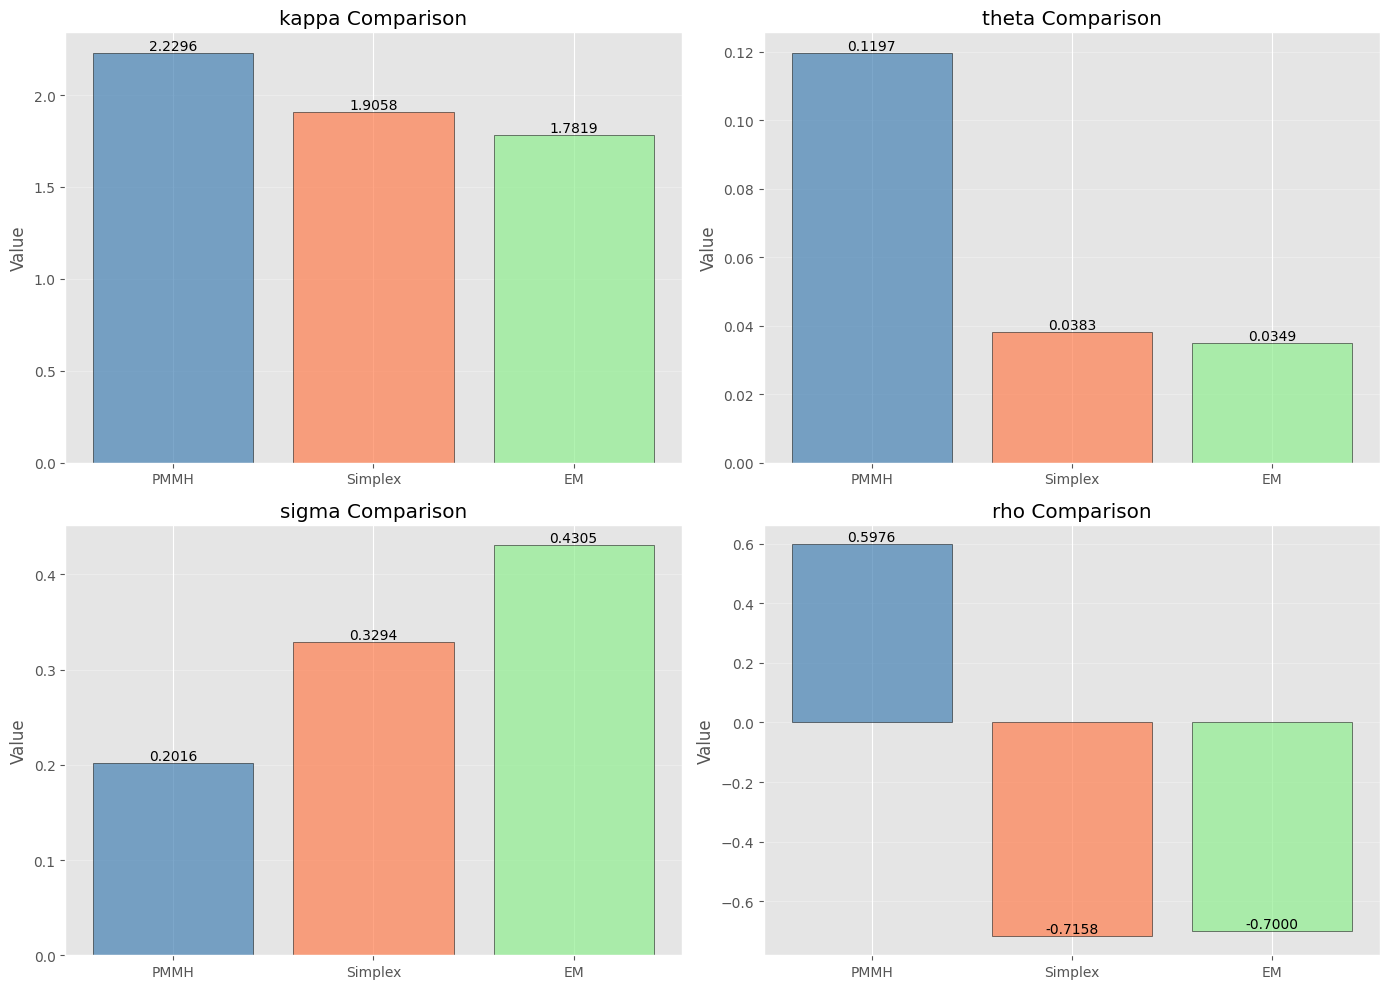

In [50]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

param_names = ['kappa', 'theta', 'sigma', 'rho']
methods = ['PMMH', 'Simplex', 'EM']
colors = ['steelblue', 'coral', 'lightgreen']

for i, param in enumerate(param_names):
    values = [
        params_pmmh.get(param, np.nan),
        params_simplex.get(param, np.nan),
        params_em.get(param, np.nan),
    ]

    bars = axes[i].bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{param} Comparison')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, val in zip(bars, values):
        if not np.isnan(val):
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f'{val:.4f}',
                ha='center',
                va='bottom',
            )

plt.tight_layout()
plt.show()

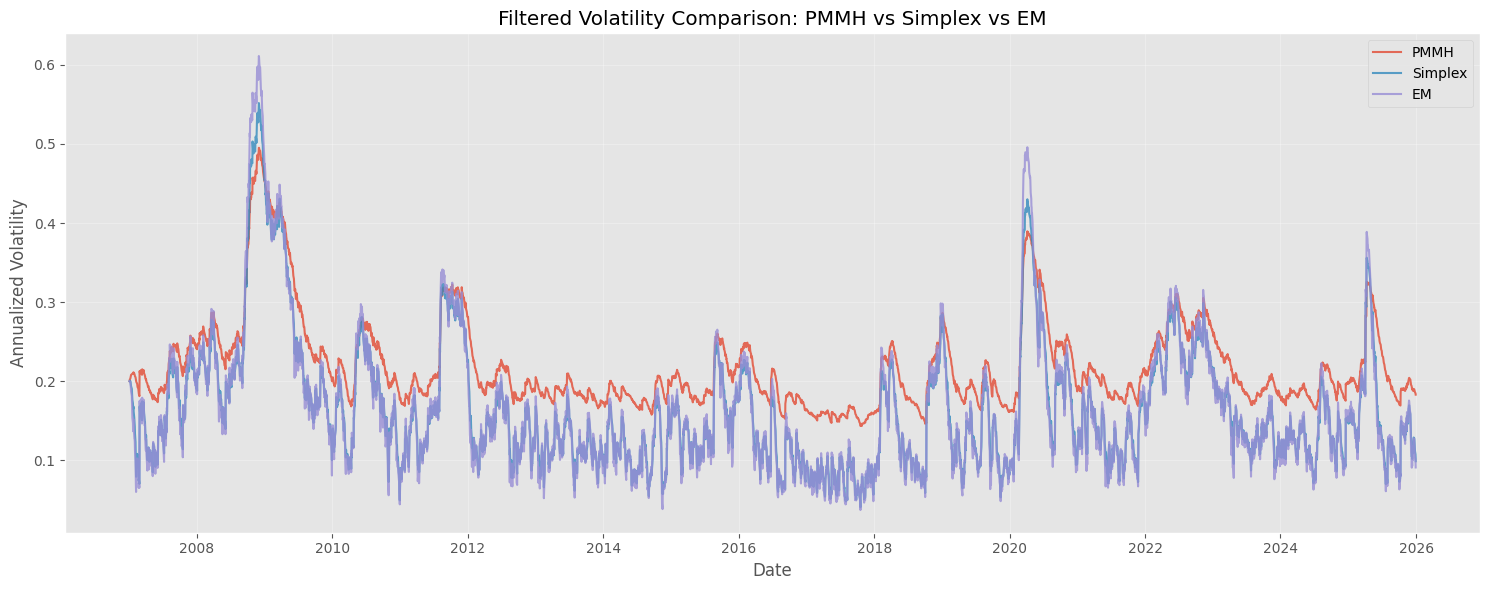

=== Volatility Correlations ===
PMMH vs Simplex: 0.9666
PMMH vs EM:      0.9480
Simplex vs EM:   0.9952


In [51]:
# Get volatility estimates from each method
# PMMH
hest.kappa = params_pmmh['kappa']
hest.theta = params_pmmh['theta']
hest.sigma = params_pmmh['sigma']
hest.rho = params_pmmh['rho']
hest.fit(n_particles=2000, verbose=False)
vol_pmmh = hest.filtered_volatility

# Simplex
hest.kappa = params_simplex['kappa']
hest.theta = params_simplex['theta']
hest.sigma = params_simplex['sigma']
hest.rho = params_simplex['rho']
hest.fit(n_particles=2000, verbose=False)
vol_simplex = hest.filtered_volatility

# EM
hest.kappa = params_em['kappa']
hest.theta = params_em['theta']
hest.sigma = params_em['sigma']
hest.rho = params_em['rho']
hest.fit(n_particles=2000, verbose=False)
vol_em = hest.filtered_volatility

# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(hest.dates, vol_pmmh, label='PMMH', linewidth=1.5, alpha=0.8)
plt.plot(hest.dates, vol_simplex, label='Simplex', linewidth=1.5, alpha=0.8)
plt.plot(hest.dates, vol_em, label='EM', linewidth=1.5, alpha=0.8)
plt.title('Filtered Volatility Comparison: PMMH vs Simplex vs EM')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlations
print("=== Volatility Correlations ===")
print(f"PMMH vs Simplex: {np.corrcoef(vol_pmmh, vol_simplex)[0,1]:.4f}")
print(f"PMMH vs EM:      {np.corrcoef(vol_pmmh, vol_em)[0,1]:.4f}")
print(f"Simplex vs EM:   {np.corrcoef(vol_simplex, vol_em)[0,1]:.4f}")

### Method Comparison Summary

| Method      | Type                | Advantages                                 | Disadvantages                        | Computational Cost      |
| ----------- | ------------------- | ------------------------------------------ | ------------------------------------ | ----------------------- |
| **PMMH**    | Bayesian MCMC       | Full posterior, uncertainty quantification | Slow, requires priors                | High (hours)            |
| **Simplex** | Direct optimization | Fast, simple, no priors                    | Local minima, no uncertainty         | Medium (minutes)        |
| **EM**      | Iterative           | Guaranteed improvement, good for SSMs      | Slow convergence, approximate M-step | Medium-High (10-30 min) |

### Discussion

1. **PMMH** is the most theoretically sound method, providing full Bayesian inference with uncertainty quantification. However, it's computationally expensive.

2. **Simplex** is the fastest method and often finds good solutions, but may get stuck in local minima and doesn't provide uncertainty estimates.

3. **EM** is a good middle ground, but for the Heston model, the M-step is approximate (requires numerical optimization), which limits its effectiveness.

4. **Paper's approach (NMLE)**: The paper uses NMLE which requires known volatilities, so it alternates between filtering and parameter estimation. This is similar to EM but uses a different parameter update rule.


## Conclusions

### Step 2 Summary

This notebook successfully addresses **Step 2** of the project requirements:

1.  **Explained paper's approach**: NMLE with switching filters (PCRLB-based)
2.  **Compared estimation methods**: PMMH, Simplex, and EM
3.  **Analyzed differences**: Computational cost, advantages, disadvantages
4.  **Visualized results**: Parameter comparisons and volatility paths

### Key Findings

- **PMMH** provides the most complete inference but is computationally expensive
- **Simplex** is fast and practical for point estimates
- **EM** is theoretically appealing but implementation for Heston model is challenging
- All methods can produce reasonable parameter estimates, but may differ due to:
  - Different optimization objectives
  - Local vs global optima
  - Computational constraints
